In [1]:
import os

from electric_meter import *
from IPython.display import HTML

In [2]:
fname='uploads/was-excel.xlsx'
fname='uploads/mine-sep2023.csv'
fname='uploads/meter_23141644_LP_03-10-2023.csv'
fname='uploads/meter_23141644_LP_01-03-2024.csv'
#fname='uploads/1694442555_9_5acc46e3.csv'
#fname='uploads/c595_1696146559_9.csv'
#meter = read_data('data/meter-big.csv')
meter = read_data(fname)
#meter = pd.read_excel(fname, skiprows=11)

In [3]:
def read_solar_data_from_noga(dir):
    # scan all .csv files in dir
    files = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f)) and f.endswith('.csv')]
    # read each file as a dataframe
    dfs = [pd.read_csv(os.path.join(dir, f)) for f in files]
    # concatenate all dataframes
    df = pd.concat(dfs)
    return df

In [4]:
def merge_solar_data(meter, use_noga_data=False):
    if use_noga_data:
        # read solar data (to fetch it, run notebooks/charts/code/fetch_noga.py)
        solar = read_solar_data('../charts/data/noga')
        solar['time'] = pd.to_datetime(solar['time'], format='%Y%m%d %H:%M:%S')
        solar.set_index('time', inplace=True)
        solar = solar.resample('1H').sum()
        solar.reset_index(inplace=True)
        
        max_solar = solar['PV generation'].max()
        solar['PV generation normalized'] = solar['PV generation'] / max_solar
        solar.drop(columns=['PV generation'], inplace=True)
        
        # add the solar data to the meter data
        meter = meter.reset_index().merge(solar, on='time', how='left').set_index('time')
    else:   
        # source: https://joint-research-centre.ec.europa.eu/photovoltaic-geographical-information-system-pvgis/pvgis-tools/hourly-radiation_en
        
        solar = pd.read_csv('data/solar_radiation.csv', skiprows=10)
        solar = solar.iloc[:-7]
        pattern = r'(\d{4})(\d{2})(\d{2}):(\d{2})(\d{2})'
        
        # Extract components into new columns
        time_cols = ['year','month', 'mday', 'hour','minute']
        solar[time_cols] = solar['time'].str.extract(pattern)
        for t in time_cols:
            solar[t] = solar[t].astype(int)
        solar['PV generation normalized'] = solar['P'].astype(float) / 1000  # convert from an installed value of 1kW
        saved_index = meter.index.copy()
        meter = meter.merge(solar[['month', 'mday', 'hour', 'PV generation normalized']], on=['month','mday', 'hour'], how='left')
        meter.index = saved_index
    return meter

In [5]:
def battery_charged_from_grid(df, capacity, charge_power, discharge_power, min_capacity=0.2):
    '''
    Take a dataframe containing meter data and simulate the loads after adding a battery.
    The battery starts at zero charge. When the rate is lowest (more precisely column 'charge_on'), it charges at rate charge_power.
    When the rate is not lowest (more precisely column 'discharge_on'), it discharges and reduces from the metered load. It stops charging when
    it reaches min_capacity*capacity (typically 20% of capacity, to increase battery life).
    '''
    
    if 'charge_on' not in df.columns:
        # use a fixed charge schedule
        df['charge_on'] = apply_filter(df, True, lambda x:filter_hour_and(x, 0, 7), default_val=False)
    if 'discharge_on' not in df.columns:
        # use a fixed charge schedule
        df['discharge_on'] = apply_filter(df, True, lambda x:filter_hour_and(x, 10, 23), default_val=False)
    
    df['charge'] = 0
    df['consumption_with_battery'] = df['consumption']
    curr_charge = 0
    # iterate over rows of df, adding charging and discharging
    for i, row in df.iterrows():
        if row['charge_on']:   # increase consumption and also the charge in the battery
            if curr_charge < capacity:
                curr_charge += charge_power
                curr_charge = min(curr_charge, capacity)
                df.loc[i, 'consumption_with_battery'] = df.loc[i, 'consumption'] + charge_power
            df.loc[i, 'charge'] = curr_charge
        else:  # draw from battery if possible
            df.loc[i, 'charge'] = curr_charge   # fallback if we don't hit any other branch
            if row['discharge_on']:
                if curr_charge > min_capacity*capacity:  # have juice
                    draw_from_battery = min(row['consumption'], discharge_power, curr_charge - min_capacity*capacity)
                    draw_from_battery = max(draw_from_battery, 0)
                    curr_charge -= draw_from_battery   
                    curr_charge = max(curr_charge, 0)
                    df.loc[i, 'charge'] = curr_charge
                    df.loc[i, 'consumption_with_battery'] = df.loc[i, 'consumption'] - draw_from_battery
                else: # battery depleted
                    pass
    
    return df

In [32]:
def battery_charged_from_solar(df, capacity, max_pv_generation, min_capacity=0.2):
    '''
    Take a dataframe containing meter data and simulate the loads after adding a battery and solar.

    The battery starts at zero charge.
    Solar generation goes to consumption first.
    Any surplus generation goes to battery.

    When it's time to discharge (defined by column 'discharge_on'), it discharges and reduces from the metered load. It stops charging when
    it reaches min_capacity*capacity (typically 20% of capacity, to increase battery life).
    '''
    
    if 'discharge_on' not in df.columns:
        # use a fixed charge schedule
        df['discharge_on'] = apply_filter(df, True, lambda x:filter_hour_and(x, 16, 23), default_val=False)

    if 'PV generation' not in df.columns:
        # use a fixed charge schedule
        df['PV generation'] = df['PV generation normalized'] * max_pv_generation
    
    df['charge'] = 0
    df['surplus generation'] = 0
    df['consumption_after'] = df['consumption']
    curr_charge = 0
    # iterate over rows of df, adding charging and discharging
    for i, row in df.iterrows():
        pv_gen = row['PV generation']
        if pv_gen > 0:
            charge_before = curr_charge
            solar_to_consumption = min(pv_gen, row['consumption'])
            solar_to_battery = pv_gen - solar_to_consumption
            df.loc[i, 'consumption_after'] = df.loc[i, 'consumption'] - solar_to_consumption
            curr_charge += solar_to_battery
            curr_charge = min(curr_charge, capacity)
            df.loc[i, 'surplus generation'] = pv_gen - solar_to_consumption - (curr_charge - charge_before)
            df.loc[i, 'charge'] = curr_charge
        else:  # no generation
            if row['discharge_on']:
                if curr_charge > min_capacity*capacity:  # have juice
                    draw_from_battery = min(row['consumption'], curr_charge - min_capacity*capacity)
                    draw_from_battery = max(draw_from_battery, 0)
                    curr_charge -= draw_from_battery   
                    curr_charge = max(curr_charge, 0)
                    df.loc[i, 'charge'] = curr_charge
                    df.loc[i, 'consumption_after'] = df.loc[i, 'consumption'] - draw_from_battery
                else: # battery depleted
                    pass    
    return df


In [19]:
meter = read_data(fname)
costs, conf = compute_costs(meter)
costs[['no_discount', 'taoz2', 'pazgas_nighttime', 'electra_nighttime', 'cellcom_nighttime']]

,no_discount,taoz2,pazgas_nighttime,electra_nighttime,cellcom_nighttime
timeperiod,,,,,
יולי 2023,491.951689,668.681207,474.954746,469.289099,473.416435
אוגוסט 2023,565.065831,772.640965,549.225773,543.945754,546.289721
ספטמבר 2023,489.116659,650.888884,477.509608,473.640591,476.259343
אוקטובר 2023,406.430747,324.638111,397.446597,394.451880,395.861412
נובמבר 2023,396.156259,318.269984,388.539572,386.000677,385.962442
דצמבר 2023,572.939104,784.227940,564.167267,561.243321,558.743158
ינואר 2024,736.058346,915.976321,721.148995,716.179211,712.379074
פברואר 2024,687.040905,841.495695,675.185145,671.233226,665.919672


In [29]:
meter = merge_solar_data(read_data(fname))

#add_battery(meter, 10, 1, 1, 0.2)
meter = battery_charged_from_solar(meter, 5, 8, 0.2)
#meter[['consumption', 'PV generation', 'charge', 'discharge_on', 'surplus generation', 'consumption_after']]
meter['consumption'] = meter['consumption_after']
costs, conf = compute_costs(meter)
costs[['no_discount', 'taoz2', 'pazgas_nighttime', 'electra_nighttime', 'surplus generation']]

,no_discount,taoz2,pazgas_nighttime,electra_nighttime,surplus generation
timeperiod,,,,,
יולי 2023,248.898813,474.868290,245.299160,244.099275,829.62700
אוגוסט 2023,306.024754,566.078887,302.162921,300.875643,785.27968
ספטמבר 2023,302.906054,502.402590,300.174638,299.264166,865.28804
אוקטובר 2023,251.372169,220.537475,249.540727,248.930246,844.48800
נובמבר 2023,268.715618,232.711016,266.843017,266.218817,634.31460
דצמבר 2023,408.998534,671.479779,406.900197,406.200751,590.88844
ינואר 2024,526.738164,772.018876,520.299613,518.153429,455.29672
פברואר 2024,480.103156,699.176740,474.645558,472.826359,538.94296


In [33]:
results = []
for panels in [0, 8, 10, 12]:
    for battery in [4.6*n for n in range(4)]:
        meter = merge_solar_data(read_data(fname))
        meter = battery_charged_from_solar(meter, battery, panels, 0.2)
        #meter[['consumption', 'PV generation', 'charge', 'discharge_on', 'surplus generation', 'consumption_after']]
        meter['consumption'] = meter['consumption_after']
        costs, conf = compute_costs(meter)
        total_cost = costs['no_discount'].sum()
        total_gen = costs['surplus generation'].sum()
        results.append(dict(panels=panels, battery=battery, cost=total_cost, gen=total_gen))

results = pd.DataFrame(data=results)
results['net'] = results['cost'] - 0.48*results['gen']

In [34]:
results

,panels,battery,cost,gen,net
0,0,0.0,4344.759541,0.00000,4344.759541
1,0,4.6,4344.759541,0.00000,4344.759541
2,0,9.2,4344.759541,0.00000,4344.759541
3,0,13.8,4344.759541,0.00000,4344.759541
4,8,0.0,3016.302884,5967.86044,151.729873
5,8,4.6,2544.715300,5069.94044,111.143889
6,8,9.2,2078.782398,4182.78716,71.044561
7,8,13.8,1651.501694,3369.22908,34.271736
8,10,0.0,2965.302151,7995.07580,-872.334233
9,10,4.6,2493.714567,7097.15580,-912.920217


In [36]:
battery=4.6
panels=8
meter = merge_solar_data(read_data(fname))
meter = battery_charged_from_solar(meter, battery, panels, 0.2)
#meter[['consumption', 'PV generation', 'charge', 'discharge_on', 'surplus generation', 'consumption_after']]
meter['consumption'] = meter['consumption_after']
meter[['consumption', 'PV generation', 'surplus generation']].sum()


consumption           4963.16404
PV generation         8909.38192
surplus generation    5329.56296
dtype: float64

In [ ]:
meter['consumption'] = meter['consumption_with_battery']
costs, conf = compute_costs(meter)
costs[['no_discount', 'taoz2', 'pazgas_nighttime', 'electra_nighttime', 'cellcom_nighttime']]

In [37]:
meter = read_data(fname)
add_battery(meter, 10, 1, 1, 0.2)
meter[['consumption', 'charge', 'consumption_with_battery', 'charge_on', 'discharge_on']]

,consumption,charge,consumption_with_battery,charge_on,discharge_on
time,,,,,
2023-06-21 08:00:00,0.277,0.0,0.277,False,False
2023-06-21 09:00:00,0.570,0.0,0.570,False,False
2023-06-21 10:00:00,0.465,0.0,0.465,False,True
2023-06-21 11:00:00,0.904,0.0,0.904,False,True
2023-06-21 12:00:00,0.626,0.0,0.626,False,True
...,...,...,...,...,...
2024-02-29 19:00:00,1.285,2.0,1.285,False,True
2024-02-29 20:00:00,4.303,2.0,4.303,False,True
2024-02-29 21:00:00,4.849,2.0,4.849,False,True


In [14]:
#meter = read_data('data/meter.csv')

costs, conf = compute_costs(meter)

In [15]:
costs

,no_discount,pazgas_daytime,pazgas_unlimited,pazgas_weekend,pazgas_nighttime,amisragas_unlimited,electra_power,electra_hitec,cellcom_flat,cellcom_home_office,cellcom_nighttime,taoz1,taoz2
timeperiod,,,,,,,,,,,,,
יולי 2023,480.898700,456.274136,456.853765,466.375076,464.283638,449.640284,456.853765,456.181365,456.853765,460.332409,462.779889,831.918762,658.848762
אוגוסט 2023,552.370140,521.796400,524.751633,536.622006,536.885971,516.466081,524.751633,524.282930,524.751633,525.303744,534.015885,934.830385,761.760385
ספטמבר 2023,478.127366,454.632540,454.220998,461.268697,466.781098,447.049088,454.220998,456.304663,454.220998,459.552708,465.558924,814.176691,641.106691
אוקטובר 2023,397.299211,379.629497,377.434250,386.213262,388.516913,371.474762,377.434250,381.151261,377.434250,382.092277,386.967344,491.941286,318.871286
נובמבר 2023,128.446006,122.693821,122.023706,123.123075,125.519395,120.097015,122.023706,123.216801,122.023706,124.629159,124.883626,301.159487,128.089487


In [16]:
result = style_table(costs)
display(result)

,חחי,פזגז יום,פזגז ללא הגבלה,פזגז סופ״ש,פזגז לילה,אמישראגז,5% אלקטרה פאואר,אלקטרה הייטק,סלקום 5%,סלקום מהבית,סלקום לילה,תעו״ז חד-חודשי,תעו״ז דו-חודשי
תקופה,,,,,,,,,,,,,
יולי 2023,480.90,456.27,456.85,466.38,464.28,449.64,456.85,456.18,456.85,460.33,462.78,831.92,658.85
אוגוסט 2023,552.37,521.80,524.75,536.62,536.89,516.47,524.75,524.28,524.75,525.30,534.02,934.83,761.76
ספטמבר 2023,478.13,454.63,454.22,461.27,466.78,447.05,454.22,456.30,454.22,459.55,465.56,814.18,641.11
אוקטובר 2023,397.30,379.63,377.43,386.21,388.52,371.47,377.43,381.15,377.43,382.09,386.97,491.94,318.87
נובמבר 2023,128.45,122.69,122.02,123.12,125.52,120.10,122.02,123.22,122.02,124.63,124.88,301.16,128.09


In [8]:
if False:
    cols = [costs.columns[i] for i in [0,1,5, 6]]
    display(style_table(costs[cols].copy()))

In [24]:
v = meter.query("timeperiod == '2023095'")

#meter.groupby('month').mean(numeric_only=True).plot()
#meter.groupby('hour').mean(numeric_only=True).plot()

In [41]:
meter

,consumption,date,month,wday,hour,wday_name,timeperiod,season,hhi_weekend
time,,,,,,,,,
2023-08-10 13:00:00,2.043,2023-08-10,8,3,13,Thursday,20230801,summer,False
2023-08-10 14:00:00,2.628,2023-08-10,8,3,14,Thursday,20230801,summer,False
2023-08-10 15:00:00,3.289,2023-08-10,8,3,15,Thursday,20230801,summer,False
2023-08-10 16:00:00,3.444,2023-08-10,8,3,16,Thursday,20230801,summer,False
2023-08-10 17:00:00,3.412,2023-08-10,8,3,17,Thursday,20230801,summer,False
...,...,...,...,...,...,...,...,...,...
2023-09-25 00:00:00,1.167,2023-09-25,9,0,0,Monday,20230901,summer,True
2023-09-25 01:00:00,0.460,2023-09-25,9,0,1,Monday,20230901,summer,True
2023-09-25 02:00:00,0.370,2023-09-25,9,0,2,Monday,20230901,summer,True


In [ ]:
if True:
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Create a pivot table for heatmap
    heatmap_data = meter.query("month == 9").pivot_table(index="wday_name", columns="hour", values="consumption", aggfunc="mean")

    # Create the heatmap using seaborn
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu", fmt="")
    plt.title("Consumption Heatmap")
    plt.xlabel("Hour")
    plt.ylabel("weekday")
    plt.show()


In [7]:
def read_solar_data(dir):
    # scan all .csv files in dir
    files = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f)) and f.endswith('.csv')]
    # read each file as a dataframe
    dfs = [pd.read_csv(os.path.join(dir, f)) for f in files]
    # concatenate all dataframes
    df = pd.concat(dfs)
    return df

In [99]:
solar = read_solar_data('../charts/data/noga')
solar['time'] = pd.to_datetime(solar['time'], format='%Y%m%d %H:%M:%S')
solar.set_index('time', inplace=True)
solar = solar.resample('1H').sum()
solar.reset_index(inplace=True)
solar

,time,PV generation
0,2023-04-01 00:00:00,0.00
1,2023-04-01 01:00:00,0.00
2,2023-04-01 02:00:00,0.00
3,2023-04-01 03:00:00,0.00
4,2023-04-01 04:00:00,0.00
...,...,...
8059,2024-03-01 19:00:00,42.41
8060,2024-03-01 20:00:00,0.00
8061,2024-03-01 21:00:00,0.00
8062,2024-03-01 22:00:00,0.00


<Axes: xlabel='time', ylabel='PV generation'>

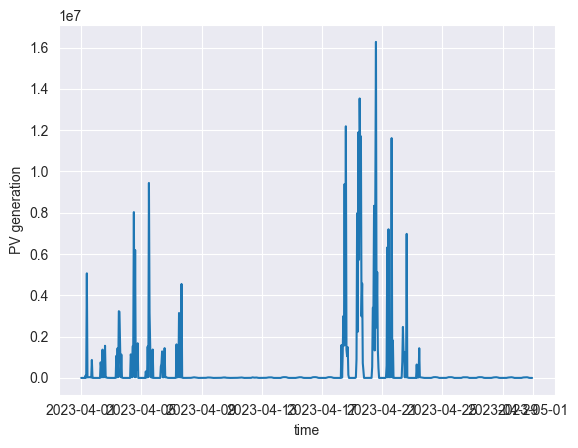

In [111]:
import seaborn as sns
d = solar.query("time < '2023-05-01' and time >= '2023-04-01'")
sns.lineplot(data=d, x='time', y='PV generation')

In [120]:
# find the argmax PV generation
max_solar = solar['PV generation'].max()
solar['max PV generation'] = solar['PV generation'] / max_solar
solar.drop(columns=['PV generation'], inplace=True)
meter.merge(solar, left_index=True, right_on='time', how='left')


,consumption,date,month,wday,hour,wday_name,timeperiod,season,hhi_weekend,charge_on,discharge_on,charge,consumption_with_battery,time,max PV generation
1952,0.277,2023-06-21,6,2,8,Wednesday,20230601,summer,False,False,False,0.0,0.277,2023-06-21 08:00:00,0.001232
1953,0.570,2023-06-21,6,2,9,Wednesday,20230601,summer,False,False,False,0.0,0.570,2023-06-21 09:00:00,0.001824
1954,0.465,2023-06-21,6,2,10,Wednesday,20230601,summer,False,False,True,0.0,0.465,2023-06-21 10:00:00,0.002135
1955,0.904,2023-06-21,6,2,11,Wednesday,20230601,summer,False,False,True,0.0,0.904,2023-06-21 11:00:00,0.002243
1956,0.626,2023-06-21,6,2,12,Wednesday,20230601,summer,False,False,True,0.0,0.626,2023-06-21 12:00:00,0.002256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,1.285,2024-02-29,2,3,19,Thursday,20240201,winter,False,False,True,2.0,1.285,2024-02-29 19:00:00,0.000006
8036,4.303,2024-02-29,2,3,20,Thursday,20240201,winter,False,False,True,2.0,4.303,2024-02-29 20:00:00,0.000006
8037,4.849,2024-02-29,2,3,21,Thursday,20240201,winter,False,False,True,2.0,4.849,2024-02-29 21:00:00,0.000001
8038,4.978,2024-02-29,2,3,22,Thursday,20240201,winter,False,False,True,2.0,4.978,2024-02-29 22:00:00,0.000000
